<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  EXP:1 Decision Tree  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate Model training and adversarial training using ART on the IRIS dataset.

## Contents

1.	[Load prereqs and data](#prereqs)
2.  [Data scale, Train and evaluate a baseline classifier](#classifier)
3.  [Adversarially train a robust classifier](#adv_training)
4.	[Evaluate the robust classifier](#evaluation)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [32]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [33]:
%watermark

2020-11-24T23:09:38+01:00

CPython 3.8.3
IPython 7.19.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 37 Stepping 5, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [34]:
# Initialization:
%reload_ext autoreload
%autoreload 2

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
# ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [37]:
%reload_ext watermark
%watermark  -d -u -a "Habtamu desalegn" -v -p numpy,pandas,scipy,matplotlib,sklearn,mlxtend

Habtamu desalegn 
last updated: 2020-11-24 

CPython 3.8.3
IPython 7.19.0

numpy 1.19.4
pandas 1.1.3
scipy 1.5.3
matplotlib 3.3.3
sklearn 0.23.2
mlxtend 0.17.3


In [36]:
# Downloading the Libraries and Dependencies:
import os
import numpy as np
import pandas as pd
from IPython.display import Image
from typing import Tuple

%matplotlib inline
import matplotlib.pyplot as plt

#### Loading the IRIS dataset

In [38]:
COLUMNS = ["sepal_length","sepal_width","petal_length","petal_width","species"]
PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(PATH, header=None, index_col=None, names = COLUMNS)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [39]:
from sklearn.preprocessing import LabelEncoder

X = df.drop('species', axis=1).values
y = df['species']

enc = LabelEncoder()
y = enc.fit_transform(y)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)

In [41]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (105, 4)
y_train.shape: (105,)
X_test.shape: (45, 4)
y_test.shape: (45,)


<a id="classifier"></a>
## 2. Preprocess ,Train and Evaluate a classifier

1. [Data Scaling](#2_1)
2. [Train a model: DecisionTree](#2_2)
3. [Evaluate the model](#2_3)

<a id="2_1"></a>
### 1. Data Scaling

Bringing features onto the same scale

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def preprocess_minmax(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Normalization -- Min-max scaling

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param X_train: Data instances.
    :param X_test: Data instances.
    :return: Rescaled values of `X_train`, `X_test`.
    """
    
    # normalize
    #print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))
    
    mms = MinMaxScaler()
    X_train_norm = mms.fit_transform(X_train)
    X_test_norm = mms.transform(X_test)
    
    return X_train_norm, X_test_norm

def preprocess_standard(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Standard scaling: Gaussian with zero mean and unit variance

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param x: Data instances.
    :param y: Labels.
    :return: Rescaled values of `x`, `y`.
    """
    
    stdsc = StandardScaler()
    X_train_std = stdsc.fit_transform(X_train)
    X_test_std = stdsc.transform(X_test)
    
    return X_train_std, X_test_std

In [43]:
# Preprocess - Training and testing set
### standard
#(X_train, X_test) = preprocess_standard(X_train[:,[0,1]], X_test[:,[0,1]])    #  0=sepal length, 1=sepal width
(X_train, X_test) = preprocess_standard(X_train[:,2:], X_test[:,2:])           #  2=petal length, 3=petal width

### normalize
#(X_train, X_test) = preprocess_minmax(X_train[:,[0,1]], X_test[:,[0,1]])     #  0=sepal length, 1=sepal width
#(X_train, X_test) = preprocess_minmax(X_train[:,2:], X_test[:,2:])           #  2=petal length, 3=petal width

### with out normalization
#(X_train, X_test) = X_train[:,[0,1]], X_test[:,[0,1]]      #  0=sepal length, 1=sepal width
#(X_train, X_test) = X_train[:,2:], X_test[:,2:]            #  2=petal length, 3=petal width


<a id="2_2_1"></a>
### 2.1 Training a DecisionTree via scikit-learn

In [44]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=4, 
                              random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

In [46]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

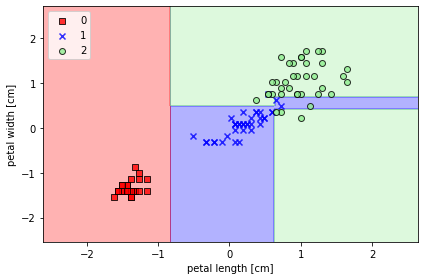

In [47]:
plot_decision_regions(X_train, y_train, model)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

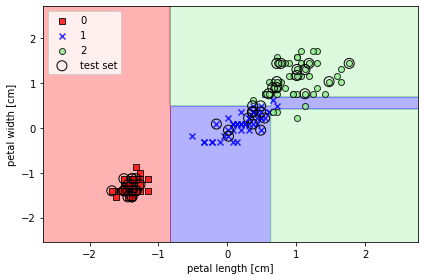

In [48]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=model,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

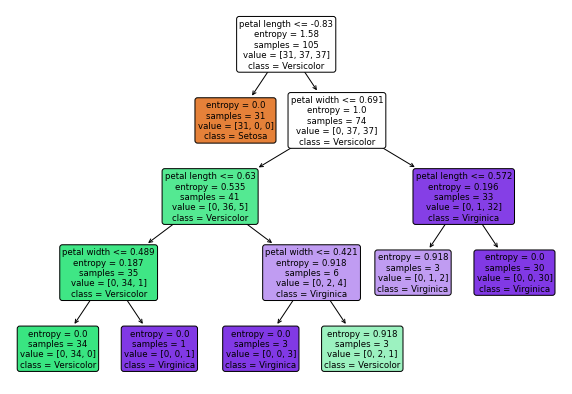

In [49]:
from sklearn.tree import plot_tree


plt.figure(figsize=(10, 7))

plot_tree(model, 
          filled=True, 
          rounded=True,
          class_names=['Setosa', 
                       'Versicolor',
                       'Virginica'],
          feature_names=['petal length', 
                         'petal width']) 

plt.show()

<a id="2_3"></a>
### Evaluate the model

Looking at different performance evaluation metrics

In [50]:
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average='macro'):
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    y_pred_bin = lb.fit_transform(y_pred)
    
    return metrics.roc_auc_score(y_test_bin, y_pred_bin, average)


y_pred = model.predict(X_test)
print(f"prediction: {y_pred}")
print(f"y_true: {y_test}")
print(f'Misclassified examples:{(y_test != y_pred).sum()}')

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Precision
print('\n[Precision]')
precision = metrics.precision_score(y_test, y_pred, average=None)
print(f'Individual: {precision[0]:.2f}, {precision[1]:.2f}, {precision[2]:.2f}')
precision = metrics.precision_score(y_test, y_pred, average='micro')
print(f"micro: {precision}")
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(f"macro: {precision}")

# Recall
print('\n[Recall]')
recall = metrics.recall_score(y_test, y_pred, average=None)
print(f'Individual: {recall[0]:.2f}, {recall[1]:.2f}, {recall[2]:.2f}')
recall = metrics.recall_score(y_test, y_pred, average='micro')
print(f"micro: {recall}")
recall = metrics.recall_score(y_test, y_pred, average='macro')
print(f"macro: {recall}")

# F1
print('\n[F1-score]')
f1 = metrics.f1_score(y_test, y_pred, average=None)
print(f'Individual: {f1[0]:.2f}, {f1[1]:.2f}, {f1[2]:.2f}')
f1 = metrics.f1_score(y_test, y_pred, average='micro')
print(f"micro: {f1}")
f1 = metrics.f1_score(y_test, y_pred, average='macro')
print(f"macro: {f1}")

# AUC
print('\n[ROC AUC]')
auc = multiclass_roc_auc_score(y_test, y_pred, average='macro')
print(f"macro: {auc}")

# classification_report
print(f"\nclassification_report:\n {metrics.classification_report(y_test, y_pred)}")

# Predicting classes and class probabilities
print(f"\nX_test:\n {X_test[0:5,:]}")
print(f"\nclass probabilities:\n {model.predict_proba(X_test[0:5,:])}")
print(f"\nPredicting classes: {model.predict(X_test[0:5,:])}")

prediction: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]
y_true: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]
Misclassified examples:0
confusion matrix:
 [[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]
Accuracy: 1.0

[Precision]
Individual: 1.00, 1.00, 1.00
micro: 1.0
macro: 1.0

[Recall]
Individual: 1.00, 1.00, 1.00
micro: 1.0
macro: 1.0

[F1-score]
Individual: 1.00, 1.00, 1.00
micro: 1.0
macro: 1.0

[ROC AUC]
macro: 1.0

classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


X_test:
 [[ 0.48403749 -0.05143998]
 [-1.26851205 -1.26670948]
 [ 1.76924049  1.43

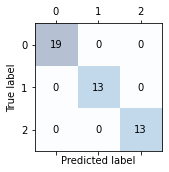

In [52]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100])

Max f1_score on max_depth   2  is  1.0


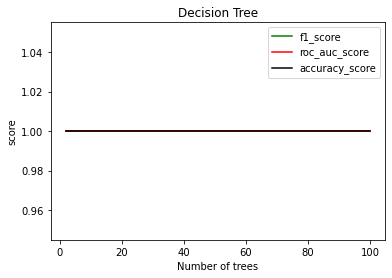

In [64]:
# imports
import time

def train_model(max_depth, X_train, y_train):
    t1 = time.time()
    model = DecisionTreeClassifier(max_depth = max_depth, random_state=42)
    model.fit(X_train, y_train)
    t2 = time.time()

    return model, t2 - t1


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    auc = multiclass_roc_auc_score(y_test, y_pred, average='macro')
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    
    return acc, recall, precision, auc, f1


max_c = 0;
max_j = 0;

y_acc = []
y_recall = []
y_precision = []
y_auc = []
y_fsc = []

x_vals = np.linspace(2,100,99).astype(int)

for j in x_vals:
    # train model
    clf, train_time = train_model(j , X_train, y_train)
    acc, recall, precision, auc, f1 = evaluate_model(clf, X_test, y_test)
    y_acc.append(acc)
    y_recall.append(recall)
    y_precision.append(precision)
    y_auc.append(auc)
    y_fsc.append(f1)
    
    if f1 > max_c:
        max_c = f1
        max_j = j
        
    
print("Max f1_score on max_depth  ",  max_j, " is ", max_c)
plt.figure()
plt.xlabel('Number of trees')
plt.ylabel('score')
plt.title('Decision Tree')
plt.plot(x_vals, y_fsc, color = "green", label = "f1_score")
plt.plot(x_vals, y_auc, color = "red", label = "roc_auc_score")
plt.plot(x_vals, y_acc, color = "black", label = "accuracy_score")

plt.legend()

## 5 Adversarial-Robustness-Toolbox for scikit-learn DecisionTree

In [34]:
from sklearn.tree import DecisionTreeClassifier
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack

#### 1 Training scikit-learn DecisionTreesClassifier and attacking with ART Zeroth Order Optimization attack

Create and apply Zeroth Order Optimization Attack with ART

Generate adversarial samples:

In [36]:
def get_adversarial_examples(X_train, X_test, y_train):
    
    # Create and fit DecisionTreeClassifier
    model = DecisionTreeClassifier(max_depth=2, random_state=42)
    model.fit(X=X_train, y=y_train)

    # Create ART classifier for scikit-learn DecisionTreeClassifier
    art_classifier = SklearnClassifier(model=model)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    X_train_adv = zoo.generate(X_train)
    X_test_adv  = zoo.generate(X_test)
    
    return X_train_adv, X_test_adv, model

### Experiment : 2

Generate adversarial samples:

In [37]:
X_train_adv, X_test_adv, model = get_adversarial_examples(X_train, X_test, y_train)

ZOO: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 19.55it/s]


#### Evaluate DecisionTreesClassifier on benign and adversarial samples

evaluate performance on those:

1. Score
2. Predict

##### Score

In [38]:
score = model.score(X_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 0.7619


In [39]:
score = model.score(X_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

Adversarial Training Score: 0.3333


#### Predict

In [51]:
print(X_train[0:5, :])
prediction = model.predict(X_train[0:5, :])
print(f"Benign Training Predicted Label: {prediction}")

[[0.6545455  0.10909089]
 [0.7454546  0.21818183]
 [0.59999996 0.0181818 ]
 [0.5272727  0.29090908]
 [0.4        0.14545454]]
Benign Training Predicted Label: [1 2 1 0 0]


In [52]:
print(X_train_adv[0:5, :])
prediction = model.predict(X_train_adv[0:5, :])
prediction
print(f"Adversarial Training Predicted Label: {prediction}")

[[0.6545455  0.10909089]
 [0.71450156 0.21818183]
 [0.5771922  0.11813124]
 [0.6272324  0.29090908]
 [0.39713916 0.04582641]]
Adversarial Training Predicted Label: [1 1 0 1 1]


##### Test score

In [53]:
score = model.score(X_test, y_test)
print("Benign Test Score: %.4f" % score)

Benign Test Score: 0.7778


In [54]:
print(X_test[:5, :])
prediction = model.predict(X_test[:5, :])
print(f"Benign Test Predicted Label: {prediction}")

[[0.7288136  0.08474576]
 [0.81355935 0.16949153]
 [0.7457627  0.1355932 ]
 [0.6101695  0.16949153]
 [0.49152544 0.18644066]]
Benign Test Predicted Label: [2 2 2 1 0]


In [55]:
score = model.score(X_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.2667


In [58]:
print(X_test_adv[0:5, :])
prediction = model.predict(X_test_adv[0:5, :])
print(f"Adversarial Test Predicted Label: {prediction}")

[[0.6969388  0.08474576]
 [0.71685153 0.16949153]
 [0.71558434 0.1355932 ]
 [0.6101695  0.16949153]
 [0.49152544 0.09944782]]
Adversarial Test Predicted Label: [1 1 1 1 1]
